# Geo-Referencing and Digitization of Scanned Maps

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Data Used](#2)
* [Imports](#3)
* [Create Masks](#4) 
* [Create Template Image](#5)
* [Prepare Search Region ](#6)
* [Match Template Multiscale](#7)
* [Georeference Image](#8) 
* [Digitize Image](#9)
* [Conclusion](#10)

### Introduction<a class="anchor" id="1"></a>

This sample guide explains the steps for automatically geo-referencing and digitizing scanned maps. Following are some of the terminologies used in this guide:
    * Scanned Map: Refers to the digital, scanned copy of a scientific paper map.
    * Geo-referencing: Refers to the process of assigning real-world coordinates to pixels of the scanned map.
    * Digitizing: Refers to the process of converting geo-referenced data to digital format(shapefile).
        
Valuable Geo-spatial information is contained in a wide variety of maps available in the form of images. Unfortunately, we can’t analyze this data without digitizing it. The conventional approach is to manually extract data and store it in a digital format. This guide details a method using computer vision techniques to automatically extract details from a set of scanned maps, find reliable feature points (control points), register the maps to different parts of the world and hence overlay the valuable Geo-spatial data depicted in these maps onto the world map.

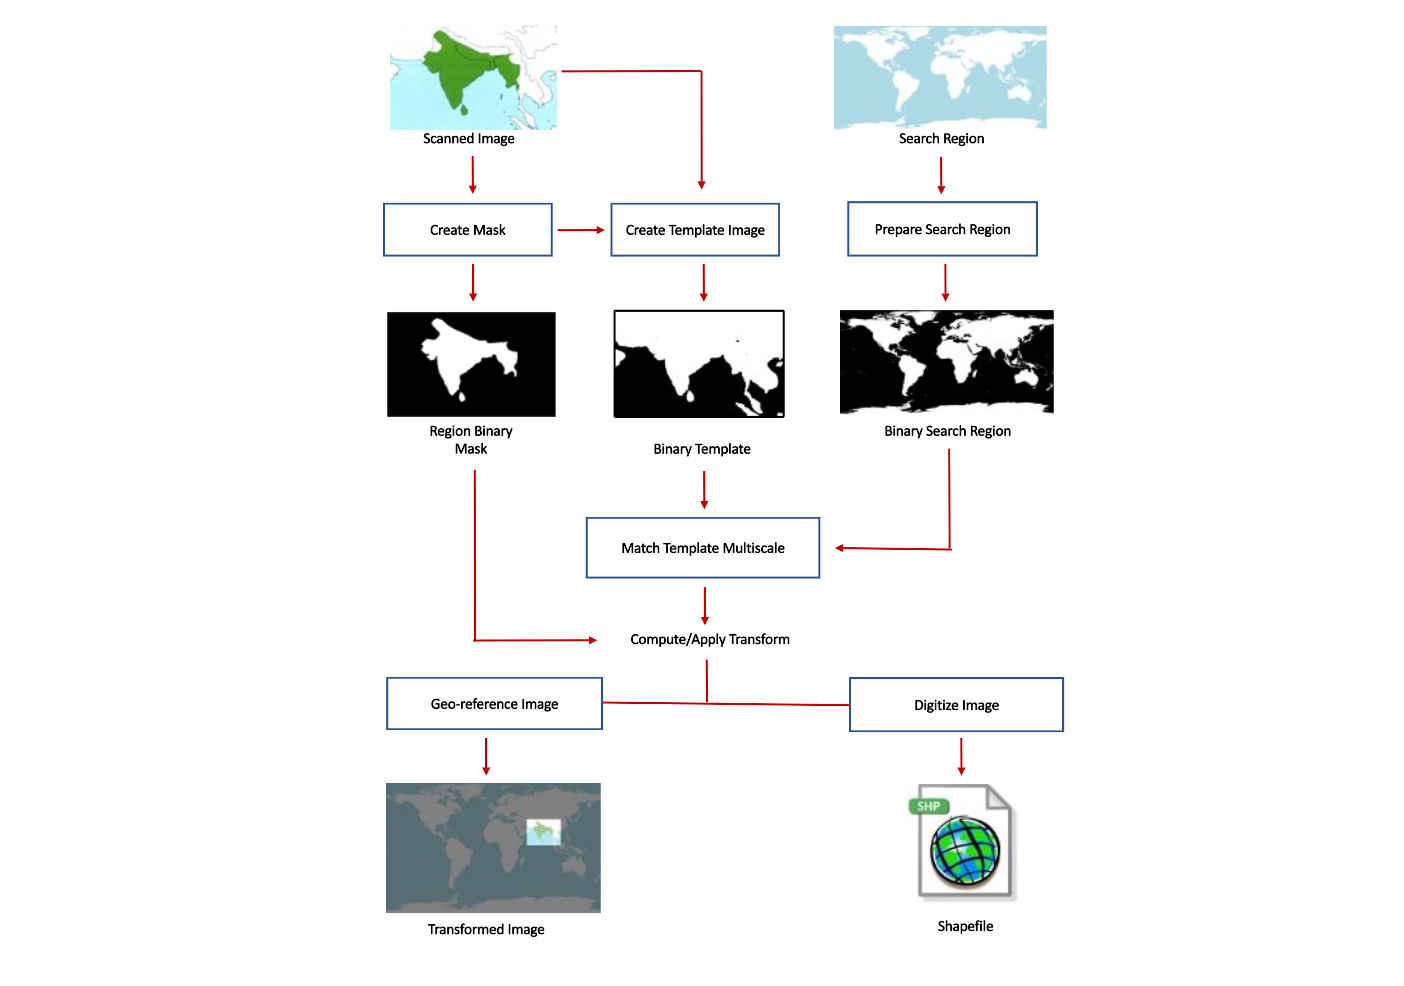

This guide illustrates the stepwise use of six APIs that are capable of geo-reference and digitize the scanned map image on the globe.


### Data Used<a class="anchor" id="2"></a>

The data used in this guide are the scanned maps extracted from the series of handbooks called "Mammals of the World" - a series which contains the information of species across the world including regions where the species are found. We extracted the images from the scanned book in order to Geo-reference and digitize the species on the world map.

Below are some sample scanned maps with depicted species region:

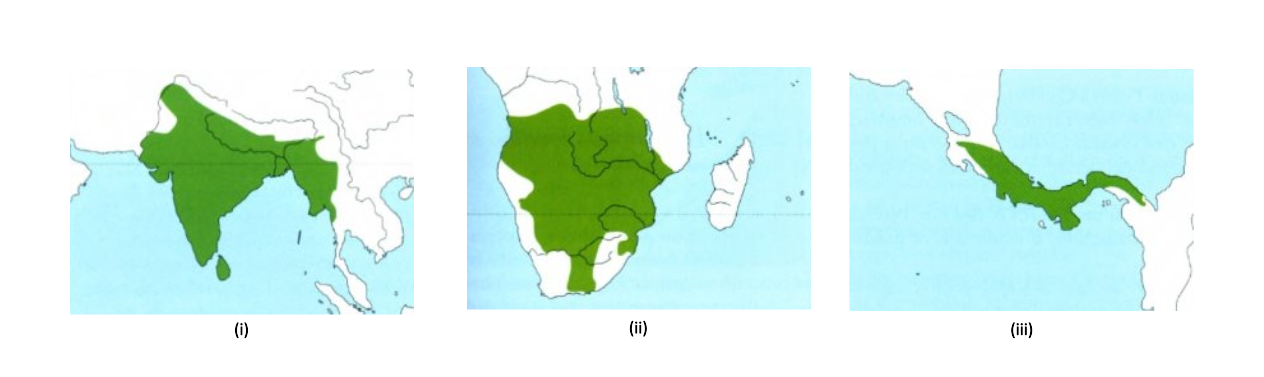

<b>(i). Bandicota bengalensis ( Bandicoot Rat ) </b> <br/>
<b>(ii). Saccostomus campestris ( Southern African Pouched Mouse )</b> <br/>
<b>(iii). Tylomys watsoni ( Watson’s Climbing Rat ) </b> <br/>

## Implementation in arcgis.learn

Let us see how scanned maps are geo-referenced and digitized with arcgis.learn

### Imports<a class="anchor" id="3"></a>

Please import the "ScannedMapDigitizer" class from arcgis.learn module.


In [22]:
from arcgis.learn import ScannedMapDigitizer

##### Object initialization

Following are the parameters to be passed:

* input_folder: The path to the folder that contains scanned map images
* output_folder: The path to the folder where intermediate results and output should get generated with image name

Note: Intermediate results are the outputs from the below-mentioned methods which are required for for the following steps as input. 

In [ ]:
smd = ScannedMapDigitizer(r"path_to_scanned_maps", r"path_to_output_folder" )

### Create Masks <a class="anchor" id="4"></a>

This method extracts binary mask images using the scanned maps corresponding to color inputs fed by the user.

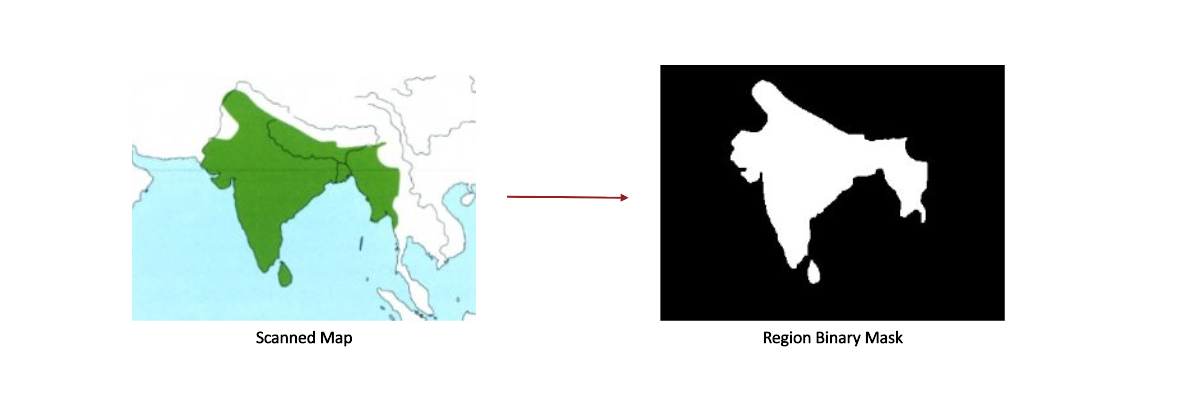

* Following are the parameters to be passed:

    * color_list:
    A list containing different color inputs(r, g, b). For example, if an image contains two colors to represent two different 
    species, the list should contain RGB values for both the colors as tuple. syntax: [(r, g, b), (r1, g1, b1)]<br/><br/>
    * color_delta: 
    A value which defines the range around the threshold value for a specific color used for creating the mask 
    images. Default value is 60.<br>
    Note: The minimum value of color_delta is 0, which means masking the image for the same color used in the color list. 
    Increasing the value will expand the threshold/range of the color, which will be useful for extracting the nearest color 
    shades. Please note that bigger value of color_delta can end up extracting the unwanted color pixels as part of the mask.
    <br/><br/>
    * kernel_size: 
    A list of 2 integers corresponding to size of the morphological filter operations closing and opening 
    respectively. Default value is None. This indicates that no morphological operations are performed. <br/><br/>
    <b style="text-align:center;">Following image shows the usage/selection of the appropriate morphological operation</b>
    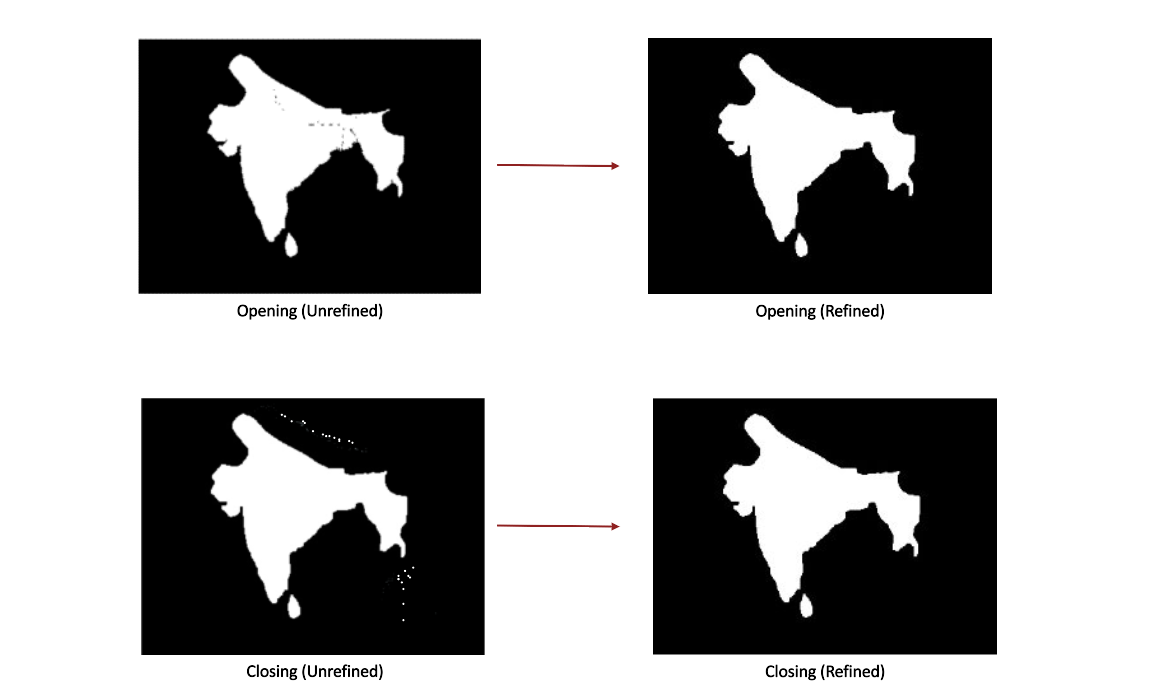
    
    By increasing/decreasing the value of kernel_size parameter we can remove the noise inside and outside the region and hence 
    can generate a better mask for the image. Please note that the use of kernel_size is only advised when there is a lot of 
    noise present after masking the image using color thresholding.
    <br/><br/>
    * kernel_type: 
    A string value defining the type/shape of the kernel. kernel type can be "rect", "elliptical" or "cross". Default value is 
    "rect" <br/><br/>
    * show_result: 
    A boolean value. Set to "True" to visualize results and set to "False" otherwise. <br/><br/>
    
* The function generates a folder with name "masks" containing binary masks for all the colors and mask_color_details.h5 which contains region wise color codes.




For a given scanned map image, the method traverses the colors in the color_list and generates a color threshold range using color_delta for all colors. The computed ranges help to generate binary masks for all colors. The masks are then further processed to remove noise using kernel_size and kernel_type parameters.

In [ ]:
smd.create_mask(color_list=[[100, 164, 8]], color_delta=70, kernel_size=[3, 3], kernel_type="rect", show_result=True)

#### Output

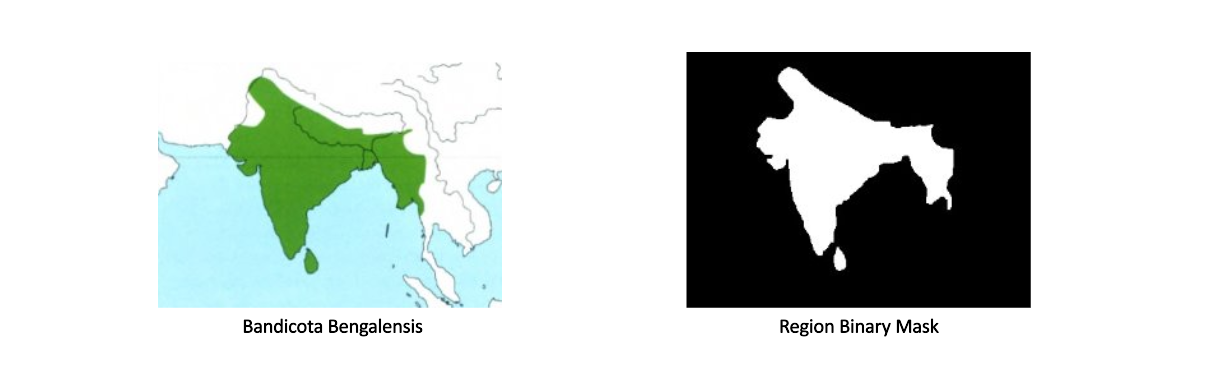

### Create Template Image <a class="anchor" id="5"></a>

This method extracts binary mask images corresponding to land region present in the scanned maps.

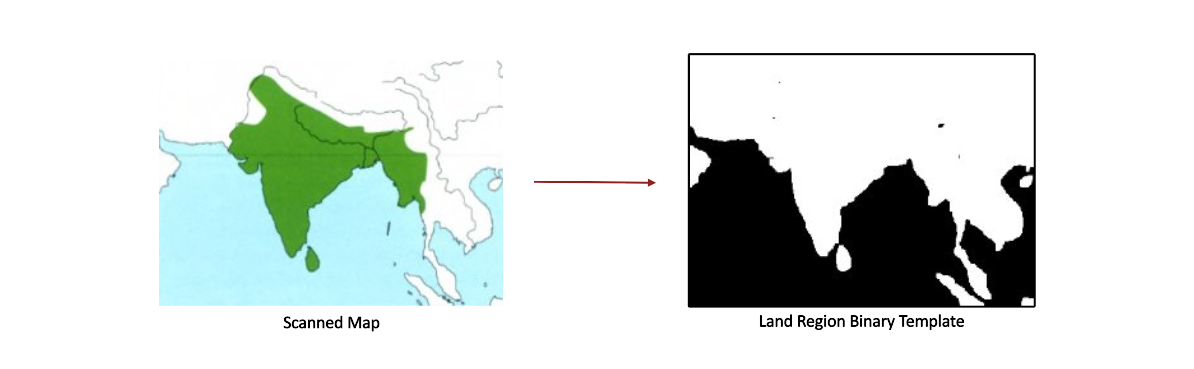

* Following are the parameters to be passed:

    * color:
    r, g, b value representing land color. The color parameter is required for extracting the land region and generating 
    the binary mask.  syntax: [r, g, b].
    syntax: [r, g, b]<br/><br/>
    * color_delta: 
    A value which defines the range around the threshold value for a specific color used for creating the mask 
    images.  Default value is 10.
    <br/><br/>
    * kernel_size: 
    An integer denoting size of the morphological kernel. Used in removing the noise from the masked image. The morphological 
    operation used is dilation. Default value is 2.  <br/><br/>
    * show_result: 
    A boolean value denoting whether to display results. Set to True to visualize results and set to False otherwise.<br/><br/>
    
* The function generates a folder with the name "template_image" with binary masks for the land region.
    






This method generates templates from scanned maps and color masks which are used in the subsequent step of template matching.

In [39]:
smd.create_template_image([254, 254,254], 10, 4, show_result= True)

#### Output

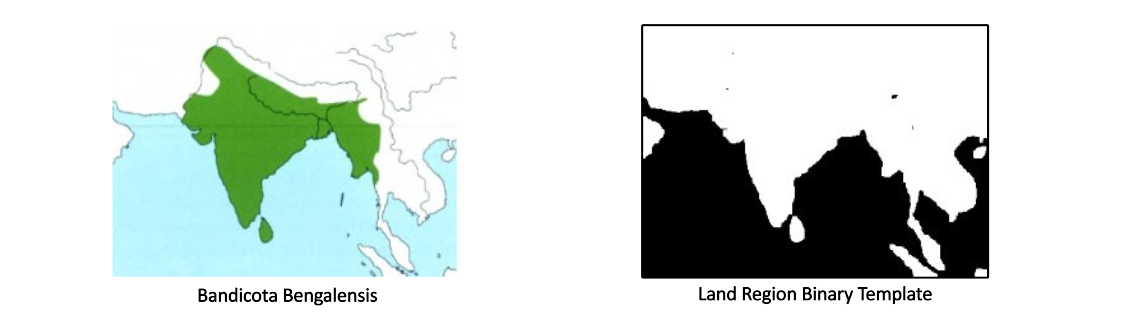

### Prepare Search Region <a class="anchor" id="6"></a>

This method prepares the search region in which the prepared templates are to be searched. Specifically, it produces the binary mask corresponding to the land region in an image (bigger than the template image). This method accepts an image or a shapefile as input. 

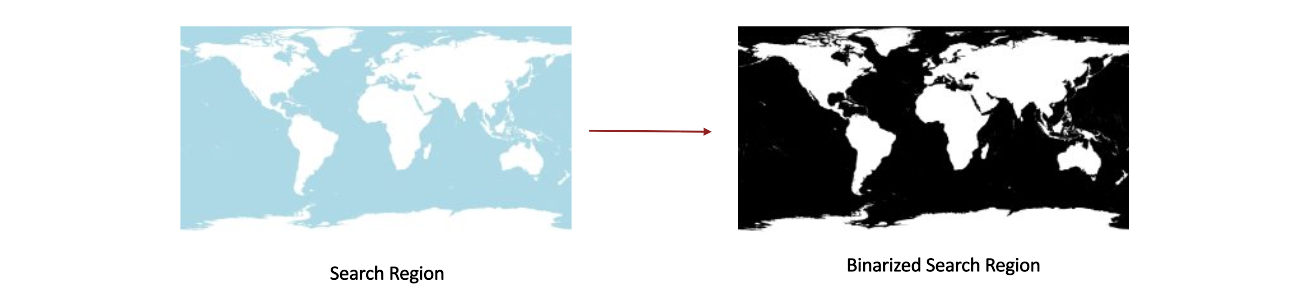

* Following are the parameters to be passed:

    * search_image: Path to the bigger image/shapefile.
    * extent: Extent defines the extreme longitue/latitude of the search region. The input value dictionary with the following
    keys:<br/>
        * spatialReference: A spatial reference can be defined using a well-known ID (WKID)<br/>
        * xmin: Left longitude value<br/>
        * ymin: Bottom latitude value<br/>
        * xmax: Right logitude value<br/>
        * ymax: Top latitude value<br/>
    * image_height: Height of the search region.
    * image_width: Width of the search region.
    * show_result: A boolean value denoting whether to display results. Set to True to visualize results and set to False 
    otherwise. 
    
* The function generates a folder with the name "search_region" with binary mask of the bigger image.


In [4]:
smd.prepare_search_region(r"path_to_bigger_image/shape_file", 2068, 3744, show_result=True)

#### Output
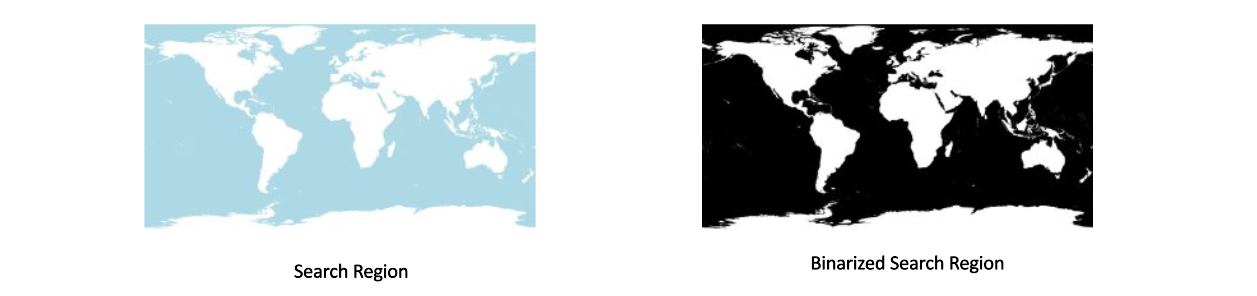

### Match Template Multiscale <a class="anchor" id="7"></a>

This method finds the location of the best match of a smaller image (template) in a larger image(world map) assuming it exists in the larger image. Multiple scales of the bigger image are used for this task because template matching is not scale-invariant.

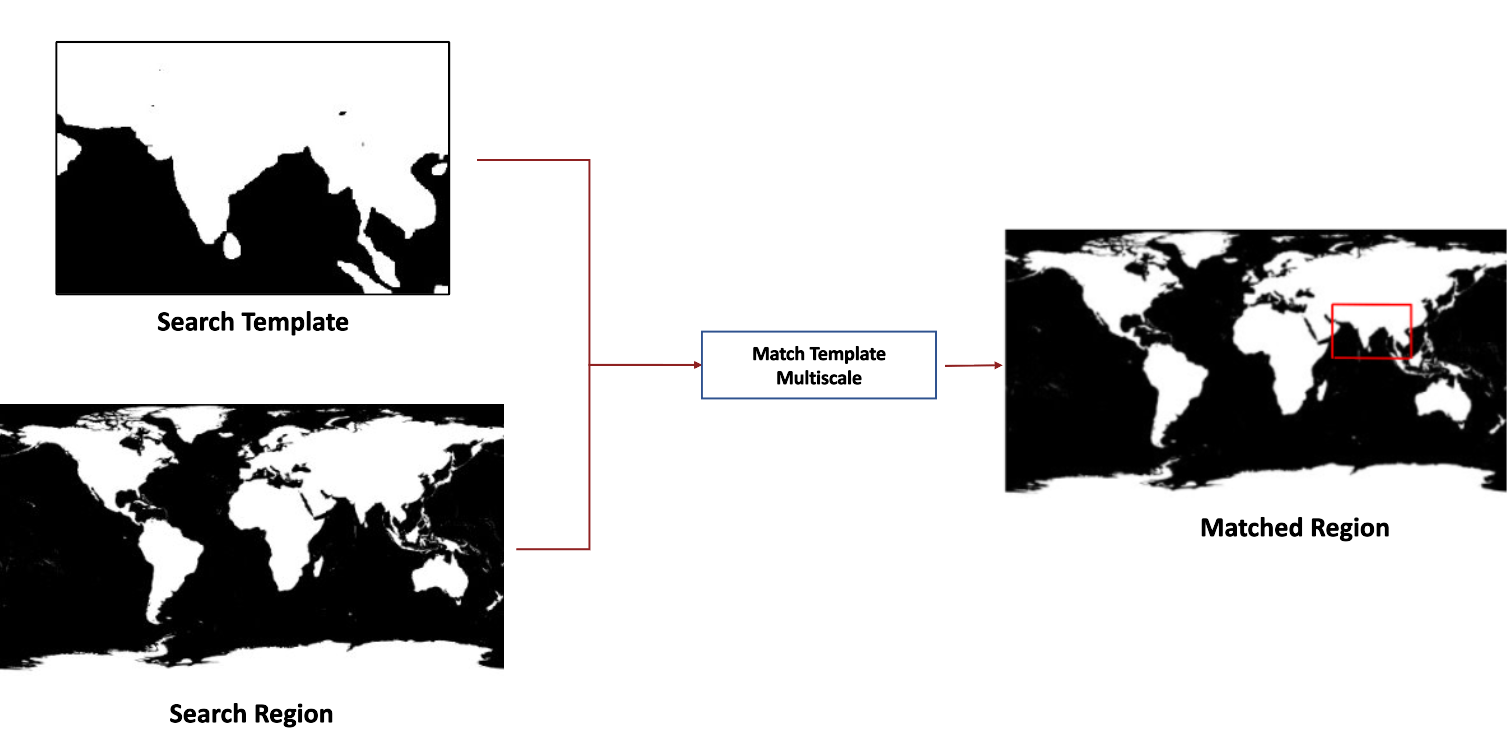


The final output is generated using the 4 pairs of points obtained from matching the entire binary scanned map template image with the binary search region image.



* Following are the parameters to be passed:

    * min_scale: An integer representing the minimum scale at which template matching is performed<br/>
    * max_scale: An integer representing maximum scale at which template matching is performed<br/>
    * num_scales: An integer representing the number of scales at which template matching is performed.<br/>
    * show_result: 
     A boolean value denoting whether to display results. Set to True to visualize results and set to False otherwise. <br/><br/>
    
    
* The function generates a folder with name the "template_match" with homogenized world image and "reference_homography.h5" that contains x-y coordinates of the matched template on world image.
    






In [28]:
smd.match_template_multiscale(0.2, 2.0, 40, show_result=True)

#### Output

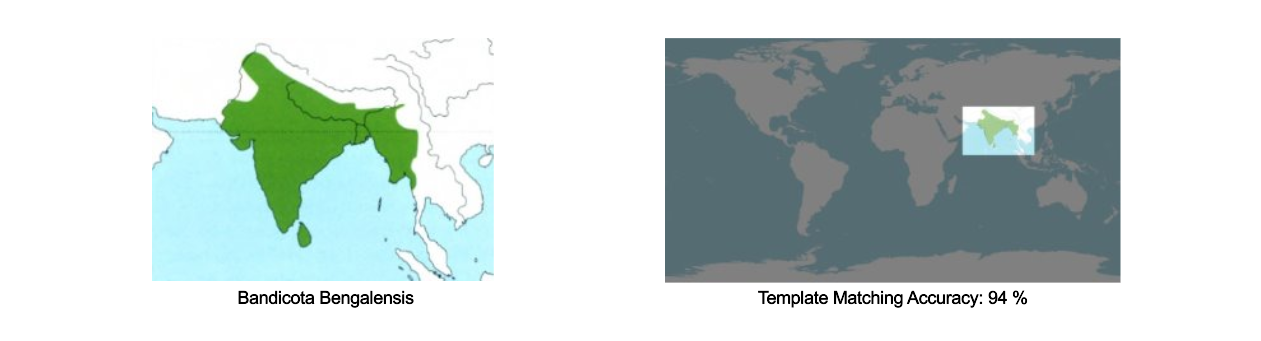

### Georeference Image <a class="anchor" id="8"></a>

This method estimates the control point pairs by traversing the contours of template image and finding the corresponding matches on the search region ROI image. The search region ROI image is obtained by padding the detected bounding box in the template matching step. The computed control points are then filtered and the outliers are removed. Filtered control points and search region extent are finally used to locate the scanned map on the world map. 

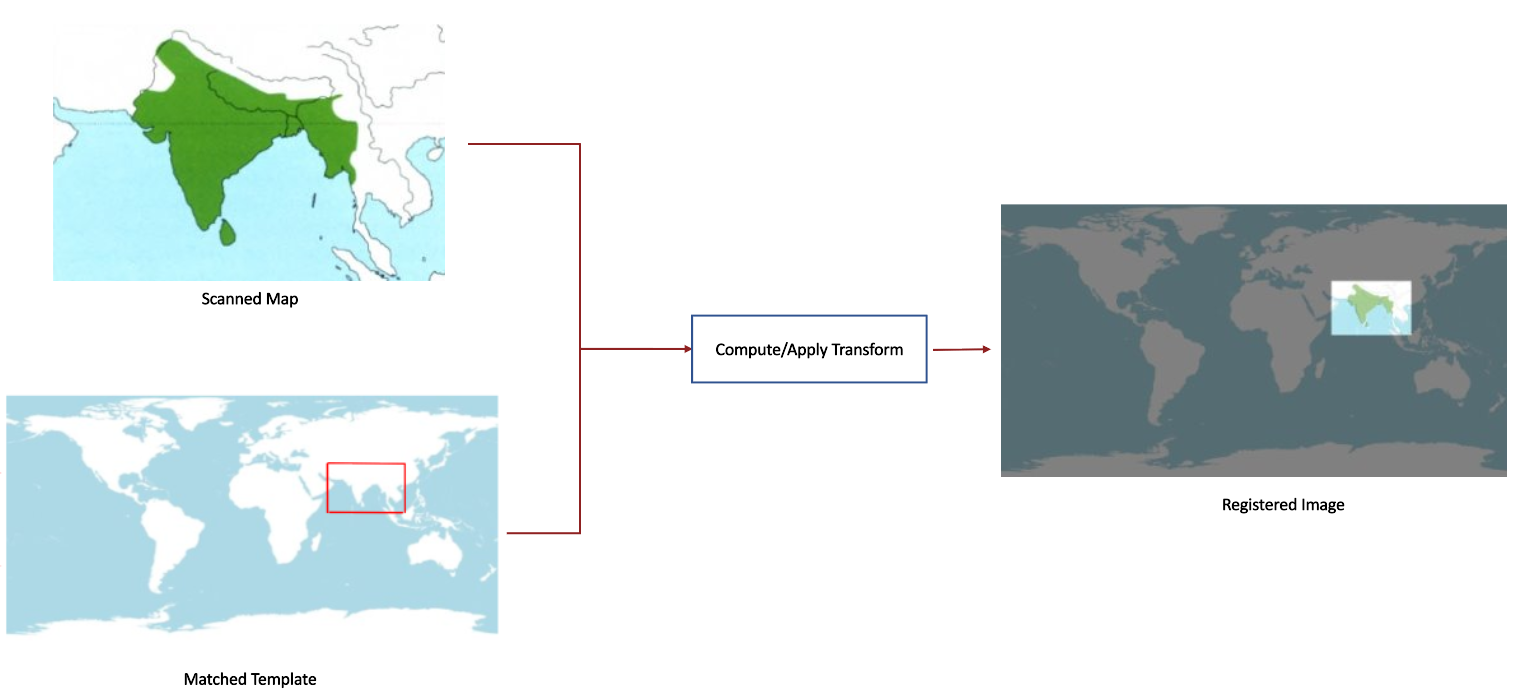




* Following are the parameters to be passed:

    * padding_param: A tuple that contains x-padding and y-padding at 0th and 1st index respectively. These padding  values are
    used to create search region ROI that is used for computing the transformation for geo-referencing the image.<br/>
    * show_result: 
    A boolean value denoting whether to display results. Set to True to visualize results and set to False otherwise.<br/><br/>
    
    
* The function generates a folder with the name "georeference_image" with warped scanned map images and an XML file that contains the geographical coordinates of the image. The geo-referenced images can be opened inside ArcGIS Pro.
    






In [44]:
smd.georeference_image(extent, (150, 50), show_result=True)

#### Output


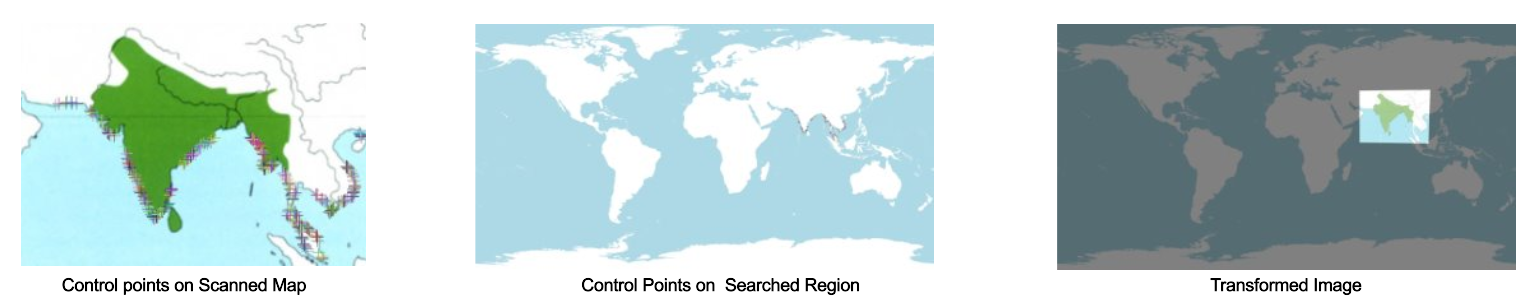

### Digitize Image <a class="anchor" id="9"></a>

This method is the final step in the pipeline that maps the species regions on the world map using the computed transformations. Also, it generates the shapefiles for the species region that can be visualized using ArcGIS Pro and further edited. Additionally, it generates a combined shapefile for all the species region corresponding to all the scanned map images.

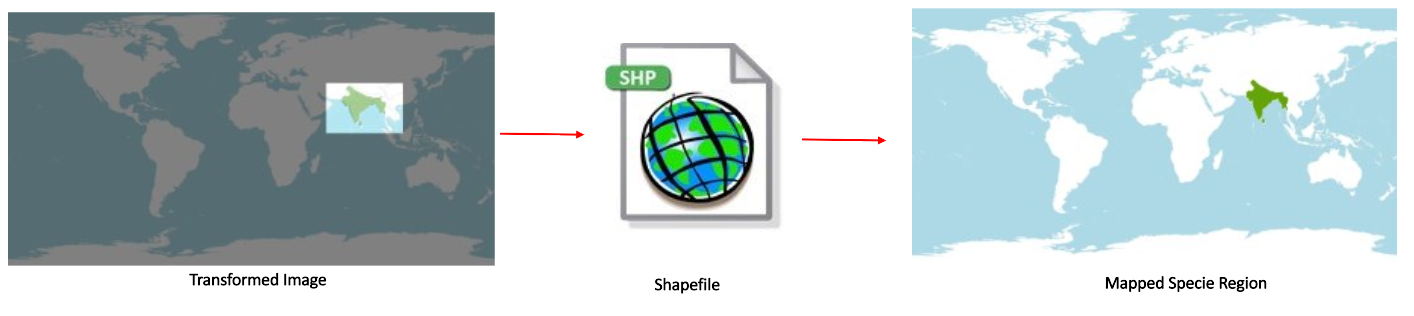




* Following are the parameters to be passed:
    * show_result: 
    A boolean value denoting whether to display results. Set to True to visualize results and set to False otherwise.<br/><br/>
    
    
* The function generates a folder with name "digitize_image" containing mapped specied regions and shapefiles
    






In [31]:
smd.digitize_image(show_result=True)

#### Output

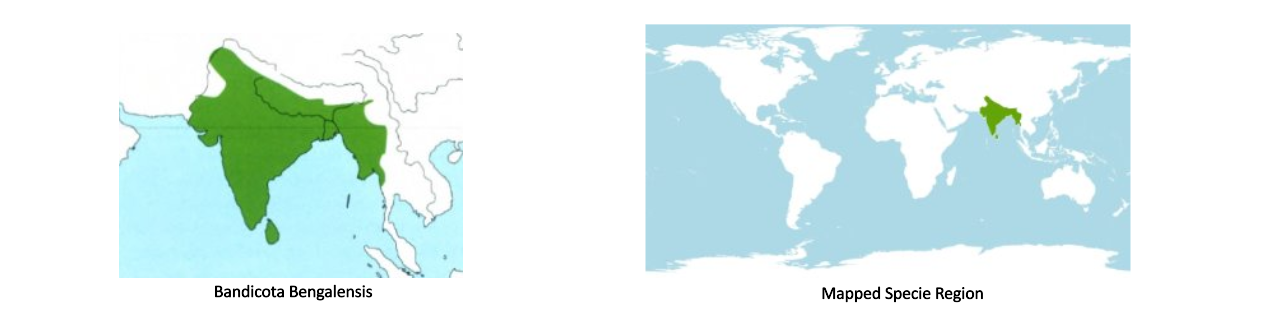

### Conclusion <a class="anchor" id="10"></a>

This guide explains how scanned maps are automatically geo-referenced and digitized. For every step in the workflow, we defined a function and also talked about its usage. This sample can be a starting point for developers to perform similar registration tasks by tuning the parameters.  